In [1]:
import os
os.chdir('/gpfs/home1/gkrtod35/Diffusion-TS')
os.getcwd()

'/gpfs/home1/gkrtod35/Diffusion-TS'

In [2]:
def __getitem__(self, ind):
    x = self.samples[ind, :, :]
    if self.regular:
        return torch.from_numpy(x).float()          # ← 여기서는 Tensor 
    mask = self.mask[ind, :, :]
    return torch.from_numpy(x).float(), torch.from_numpy(mask)

In [3]:
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from engine.solver import Trainer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one, unnormalize_to_zero_to_one

In [10]:
df = pd.read_csv('/home1/gkrtod35/ISF/TimeGAN/Origin_data/merged_data_processed_seoul.csv', low_memory=False)
df = df.drop(['Idx','date','time','일시'], axis=1)    # date, time, year 컬럼 제거
data_array = df.values                             # shape = (전체시계열길이 T, 변수개수 D)

In [11]:
df.head()

,solar generation,기온(°C),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),중하층운량(10분위),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,0.0,3.3,3.8,250.0,65.0,5.0,-2.6,1001.9,1012.5,0.0,0.0,0.0,6.0,6.0,0.0,0.1,-0.2,0.0,1.5
1,0.0,2.6,2.3,250.0,66.0,4.9,-3.1,1002.2,1012.9,0.0,0.0,0.0,0.0,0.0,-0.1,0.1,-0.2,0.1,1.5
2,0.0,1.7,1.7,250.0,67.0,4.6,-3.7,1002.4,1013.1,0.0,0.0,0.0,0.0,0.0,-0.3,0.0,-0.2,0.0,1.5
3,0.0,1.4,1.4,250.0,60.0,4.1,-5.5,1002.2,1012.9,0.0,0.0,0.0,0.0,0.0,-0.4,0.0,-0.2,0.1,1.5
4,0.0,0.9,2.8,270.0,59.0,3.8,-6.2,1002.5,1013.2,0.0,0.0,0.0,0.0,0.0,-0.6,0.0,-0.2,0.0,1.5


In [12]:
seq_len = 24
seqs = []
for i in range(len(data_array) - seq_len + 1):
    seqs.append(data_array[i : i + seq_len, :])
seqs = np.stack(seqs, axis=0)                      # shape = (N, 24, D)

n_train = int(len(seqs) * 0.8)
train = seqs[:n_train]                             # (n_train, 24, D)
test  = seqs[n_train:]                             # (N-n_train, 24, D)

# 스케일링, 정규화

scaler = MinMaxScaler()
# train: (n_train*72, D) → fit → reshape back
train_scaled = scaler.fit_transform(train.reshape(-1, train.shape[-1]))
train_scaled = normalize_to_neg_one_to_one(train_scaled).reshape(train.shape)
# test: 같은 방식으로 transform → reshape → normalize
test_scaled = scaler.transform(test.reshape(-1, test.shape[-1]))
test_scaled = normalize_to_neg_one_to_one(test_scaled).reshape(test.shape)

# PyTorch Dataset / DataLoader 
class SeqDataset(Dataset):
    def __init__(self, data, pred_length=72, regular=True):
        """
        data: np.ndarray, shape = (N, seq_len, num_features)
        pred_length: int, 마스킹할 마지막 구간 길이
        regular: bool, True면 __getitem__이 x만 반환, 
                      False면 (x, mask)를 반환
        """
        self.data = data
        self.regular = regular
        self.pred_length = pred_length

        # mask 생성: True=모델에 입력, False=예측할 구간
        # shape = (N, seq_len, num_features)
        self.mask = np.ones_like(data, dtype=bool)
        # 마지막 pred_length timesteps 만 False
        self.mask[:, -pred_length:, :] = False

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        if self.regular:
            # 학습 시에는 x만 반환 → Trainer.train() 에서 .to(device) 가능
            return x
        # 평가(restore) 시에는 (x, mask) 반환
        m = torch.from_numpy(self.mask[idx]).bool()
        return x, m

# training loader: regular=True → 튜플이 아닌 Tensor 하나만 반환
train_ds = SeqDataset(train_scaled, pred_length=72, regular=True)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# testing loader: regular=False → (x, mask) 반환
test_ds  = SeqDataset(test_scaled, pred_length=72, regular=False)
test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [13]:
# 모델 설정 및 학습
class Args:
    def __init__(self):
        self.config_path = './Config/solar.yaml'
        self.save_dir    = './forecasting_exp'
        self.gpu         = 0
        os.makedirs(self.save_dir, exist_ok=True)

args   = Args()
configs = load_yaml_config(args.config_path)
device  = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

model   = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(
    config=configs,
    args=args,
    model=model,
    dataloader={'dataloader': train_loader}
)
trainer.train()   # 이제 next(self.dl) 은 Tensor 하나만 반환합니다

# 6) 테스트 및 MSE 계산 – 5회 복원 샘플 합치기
seq_len, feat_num = test_scaled.shape[1], test_scaled.shape[2]

# (1) 원본 시계열 역스케일
real = scaler.inverse_transform(
           unnormalize_to_zero_to_one(test_scaled.reshape(-1, feat_num))
       ).reshape(test_scaled.shape)

# (2) 5회 복원-샘플링
n_runs  = 5
samples = []
for _ in range(n_runs):
    # trainer.restore  호출 → (seq_len, feat_num) 크기 샘플 1개
    sample_i, *_ = trainer.restore(
        test_loader,
        shape=[seq_len, feat_num],
        coef=1e-2,
        stepsize=5e-2,
        sampling_steps=200
    )
    sample_i = scaler.inverse_transform(
                   unnormalize_to_zero_to_one(sample_i.reshape(-1, feat_num))
               ).reshape(test_scaled.shape)
    samples.append(sample_i)

samples = np.stack(samples, axis=0)        # (5, batch, seq_len, feat_num)

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (24) must match the size of tensor b (48) at non-singleton dimension 1

In [5]:

# (3) 예: 5개를 단순 평균하여 최종 재구성치로 사용
#     ↳ 필요에 따라 median, weighted mean 등으로 바꿔도 됩니다.
sample_agg = samples.mean(axis=0)          # (batch, seq_len, feat_num)

# (4) 마스크 위치에서만 MSE
mask = test_ds.mask
mse  = mean_squared_error(sample_agg[~mask], real[~mask])
print("Test MSE (5-run avg):", mse)

Test MSE (5-run avg): 1325.8129709545854


In [7]:
samples.shape

(5, 15625, 24, 19)

In [ ]:
# ────────────────────────────────────────────────────────────────
# 6) 테스트 및 MSE 계산
# ────────────────────────────────────────────────────────────────
seq_len, feat_num = test_scaled.shape[1], test_scaled.shape[2]
real = scaler.inverse_transform(unnormalize_to_zero_to_one(test_scaled.reshape(-1, feat_num)))\
           .reshape(test_scaled.shape)

# 복원 샘플링
sample, *_ = trainer.restore(test_loader,
                             shape=[seq_len, feat_num],
                             coef=1e-2,
                             stepsize=5e-2,
                             sampling_steps=200) # denosing 단계
sample = scaler.inverse_transform(unnormalize_to_zero_to_one(sample.reshape(-1, feat_num)))\
               .reshape(test_scaled.shape)

mask = test_ds.mask
mse  = mean_squared_error(sample[~mask], real[~mask])
print("Test MSE:", mse)

In [15]:
seqs.shape

(78124, 24, 19)

In [32]:
print(sample.shape)
print(real.shape)

(15625, 24, 19)
(15625, 24, 19)


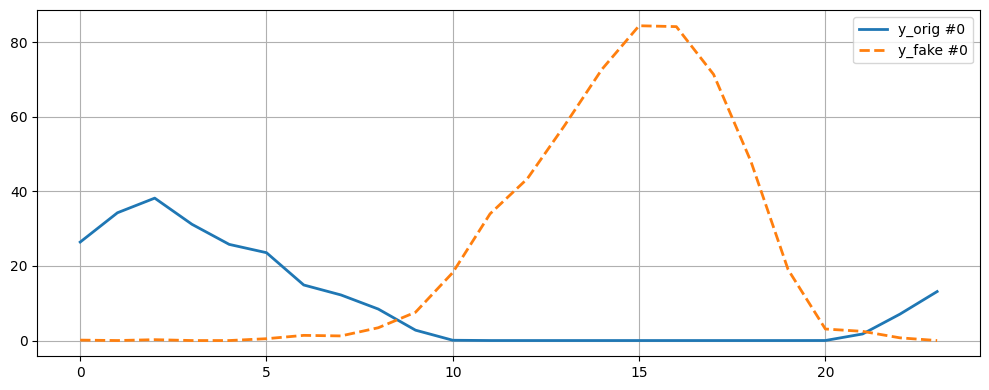

In [33]:
import matplotlib.pyplot as plt

feat = 0   # 비교하고 싶은 피처 인덱스 (0~18)
plt.figure(figsize=(10,4))

# 
x = list(range(24))
y_orig = seqs[5000, :, feat]
y_fake = samples_all[5000, :, feat]

plt.plot(x, y_orig, label='y_orig #0', lw=2)
plt.plot(x, y_fake, '--', label='y_fake #0', lw=2)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import os, gc, torch, numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import (
    normalize_to_neg_one_to_one, unnormalize_to_zero_to_one
)
from engine.solver import Trainer

# ───────────────────────────────────────────────────────────
# 공통 설정
# ───────────────────────────────────────────────────────────
seq_len = 24                # 앞서 정의한 고정 길이
pred_len = 72               # 마스킹 길이
batch_size = 32
n_folds   = 5               # 20 % × 5 = 100 %
n_runs    = 1               # 각 fold 안에서 샘플 평균 낼 횟수(메모리 고려해 1로 시작)
device    = torch.device('cuda:0')

class SeqDataset(Dataset):
    def __init__(self, data, pred_length, regular=True):
        self.data, self.pred_length, self.regular = data, pred_length, regular
        self.mask = np.ones_like(data, dtype=bool)
        self.mask[:, -pred_length:, :] = False
    def __len__(self):  return len(self.data)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        if self.regular: return x
        m = torch.from_numpy(self.mask[idx]).bool()
        return x, m

# ──────────────────────────────
# A. CSV 로드 & sil
# ──────────────────────────────
df = pd.read_csv('/home1/gkrtod35/ISF/TimeGAN/Origin_data/merged_data_processed.csv')
df = df.drop(['Idx'], axis=1)

seq_len = 24
data_array = df.values
seqs = np.stack([data_array[i:i+seq_len]          # (N, 24, D)
                 for i in range(len(data_array)-seq_len+1)], axis=0)


In [25]:
# ───────────────────────────────────────────────────────────
# 0) 시퀀스화한 전체 배열 `seqs` 가 이미 준비됐다고 가정
#     shape = (N, 24, D)
# ───────────────────────────────────────────────────────────
N, _, D = seqs.shape
fold_size = N // n_folds

samples_all = np.empty_like(seqs)   # 결과를 원위치에 채울 그릇
mse_list    = []

for fold in range(n_folds):
    print(f'\n▶ Fold {fold+1}/{n_folds}')

    # -------------------------------------------------------
    # A. train / test 분리
    # -------------------------------------------------------
    test_start, test_end = fold * fold_size, (fold + 1) * fold_size if fold < n_folds-1 else N
    test_seqs  = seqs[test_start:test_end]
    train_seqs = np.concatenate([seqs[:test_start], seqs[test_end:]], axis=0)

    # -------------------------------------------------------
    # B. 스케일러 fit (train 기준) & 정규화
    # -------------------------------------------------------
    scaler = MinMaxScaler()
    train_scaled = normalize_to_neg_one_to_one(
        scaler.fit_transform(train_seqs.reshape(-1, D))
    ).reshape(train_seqs.shape)
    test_scaled = normalize_to_neg_one_to_one(
        scaler.transform(test_seqs.reshape(-1, D))
    ).reshape(test_seqs.shape)

    # -------------------------------------------------------
    # C. 데이터로더
    # -------------------------------------------------------
    train_dl = DataLoader(SeqDataset(train_scaled, pred_len, regular=True),
                          batch_size=batch_size, shuffle=True)
    ### ① DataLoader를 훨씬 작은 배치로
    test_dl = DataLoader(
        SeqDataset(test_scaled, pred_len, regular=False),
        batch_size=64,          # ← 64(또는 32) 정도로
        shuffle=False
    )

    # ────────────────────────────────────────────────
    # D. 모델·Trainer 생성  ← 반드시 restore보다 앞
    # ────────────────────────────────────────────────
    cfg   = load_yaml_config('./Config/solar.yaml')
    model = instantiate_from_config(cfg['model']).to(device)

    class Args:
        config_path = './Config/solar.yaml'
        save_dir    = f'./exp_fold{fold}'
        gpu         = 0
    trainer = Trainer(cfg, Args, model, dataloader={'dataloader': train_dl})
    trainer.train()

    # ────────────────────────────────────────────────
    # E. 복원-샘플링 (n_runs 번) → 평균
    # ────────────────────────────────────────────────
    agg = None
    for r in range(n_runs):
        with torch.no_grad():
            samp, *_ = trainer.restore(
                test_dl, shape=[seq_len, D],
                coef=1e-2, stepsize=5e-2, sampling_steps=200
            )
        # trainer.restore 가 이미 NumPy 반환 → .cpu() 필요 X
        if torch.is_tensor(samp):
            samp = samp.cpu().numpy()

        samp = scaler.inverse_transform(
                   unnormalize_to_zero_to_one(samp.reshape(-1, D))
               ).reshape(test_seqs.shape)

        agg = samp if agg is None else agg + (samp - agg) / (r + 1)

    samples_all[test_start:test_end] = agg     # 원래 위치에 삽입

    # ────────────────────────────────────────────────
    # F. fold-별 MSE
    # ────────────────────────────────────────────────
    real_fold = scaler.inverse_transform(
        unnormalize_to_zero_to_one(test_scaled.reshape(-1, D))
    ).reshape(test_seqs.shape)
    mask = SeqDataset(test_scaled, pred_len, regular=False).mask
    mse  = mean_squared_error(agg[~mask], real_fold[~mask])
    mse_list.append(mse)
    print(f'fold MSE = {mse:.4f}')

    # ────────────────────────────────────────────────
    # G. 메모리 정리
    # ────────────────────────────────────────────────
    del trainer, model, train_dl, test_dl, agg
    torch.cuda.empty_cache()


▶ Fold 1/5


loss: 0.122393: 100%|██████████| 100000/100000 [2:18:27<00:00, 12.04it/s] 


training complete


conditional sampling loop time step: 100%|██████████| 200/200 [00:09<00:00, 20.27it/s]


fold MSE = 1659.8665

▶ Fold 2/5


loss: 0.107051: 100%|██████████| 100000/100000 [2:21:41<00:00, 11.76it/s] 


training complete


conditional sampling loop time step: 100%|██████████| 200/200 [00:10<00:00, 19.87it/s]


fold MSE = 1676.6718

▶ Fold 3/5


loss: 0.108298: 100%|██████████| 100000/100000 [2:18:26<00:00, 12.04it/s] 


training complete


conditional sampling loop time step: 100%|██████████| 200/200 [00:09<00:00, 20.57it/s]


fold MSE = 1735.0410

▶ Fold 4/5


loss: 0.114423: 100%|██████████| 100000/100000 [2:18:37<00:00, 12.02it/s] 


training complete


conditional sampling loop time step: 100%|██████████| 200/200 [00:09<00:00, 20.26it/s]


fold MSE = 1806.0113

▶ Fold 5/5


loss: 0.112609: 100%|██████████| 100000/100000 [2:25:49<00:00, 11.43it/s] 


training complete


conditional sampling loop time step: 100%|██████████| 200/200 [00:09<00:00, 20.48it/s]


fold MSE = 2003.9587


In [35]:
import pickle

with open('samples_all.pkl', 'wb') as f:
    pickle.dump(samples_all, f)
print("▶ samples_all.pkl로 저장 완료")

▶ samples_all.pkl로 저장 완료
